Credit Risk Modelling

In [7]:
# Load necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [8]:
df_accepted_cleaned = pd.read_csv('/Users/Cathaml/Desktop/accepted_cleaned.csv', header=0, low_memory=False)

In [9]:
df = df_accepted_cleaned
# Drop rows with missing target
df = df[df['loan_status'].notna()]
# 4. Define the target variable (binary classification)
# Simplify target to: 1 = Default / Charged Off, 0 = Fully Paid
df['loan_status'] = df['loan_status'].replace({
    'Fully Paid': 0,
    'Charged Off': 1,
    'Default': 1,
    'Late (31-120 days)': 1,
    'Late (16-30 days)': 1
})
df = df[df['loan_status'].isin([0, 1])]  # remove other statuses

# 5. Select features (simplified for demo — customize this!)
features = [
    'loan_amnt', 'term', 'int_rate', 'installment', 'emp_length',
    'annual_inc', 'dti', 'delinq_2yrs', 'revol_util', 'total_acc'
]

df = df[features + ['loan_status']].dropna()  # remove rows with missing values

# 6. Feature preprocessing
X = df.drop('loan_status', axis=1)
y = df['loan_status']

# Normalize numeric columns
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 7. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# 8. Model training (Logistic Regression as a baseline)
model = LogisticRegression()
model.fit(X_train, y_train)

# 9. Model evaluation
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[200361   3383]
 [ 46244   3208]]
              precision    recall  f1-score   support

           0       0.81      0.98      0.89    203744
           1       0.49      0.06      0.11     49452

    accuracy                           0.80    253196
   macro avg       0.65      0.52      0.50    253196
weighted avg       0.75      0.80      0.74    253196



Strengths: 
1. Very high recall for class 0 (Fully Paid): 98% — the model is great at detecting borrowers who are likely to repay.
2. High accuracy overall: 80% — looks strong on the surface.

But Major Weakness:
1. Very poor recall for class 1 (Defaulted): Only 6%. That means: 94% of actual defaulters are missed.
2. F1-score for defaulters is only 0.11 — this indicates the model is practically useless at predicting defaults, which is actually your main goal in credit risk modeling.

This model is currently good at predicting safe loans, but fails at identifying risky ones.
That’s a critical flaw in credit risk modeling — the cost of false negatives (missing defaulters) is very high.

Strategy 1: Logistic Regression with class_weight='balanced'

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Train a Logistic Regression with balanced class weights
model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[138410  65334]
 [ 19543  29909]]
              precision    recall  f1-score   support

           0       0.88      0.68      0.77    203744
           1       0.31      0.60      0.41     49452

    accuracy                           0.66    253196
   macro avg       0.60      0.64      0.59    253196
weighted avg       0.77      0.66      0.70    253196



Strategy 2: Apply SMOTE (Synthetic Minority Oversampling Technique)

In [11]:
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# 1. Resample the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 2. Train Logistic Regression on resampled data
model = LogisticRegression(max_iter=1000)
model.fit(X_train_resampled, y_train_resampled)

# 3. Predict and Evaluate
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[138312  65432]
 [ 19504  29948]]
              precision    recall  f1-score   support

           0       0.88      0.68      0.77    203744
           1       0.31      0.61      0.41     49452

    accuracy                           0.66    253196
   macro avg       0.60      0.64      0.59    253196
weighted avg       0.77      0.66      0.70    253196



The SMOTE-based model yielded slightly better recall and F1-score for the minority class, making it more suitable for risk-averse financial applications where minimizing false negatives is critical. Thus, we recommend SMOTE as the preferred approach for downstream modeling.

ROC & AUC Curve

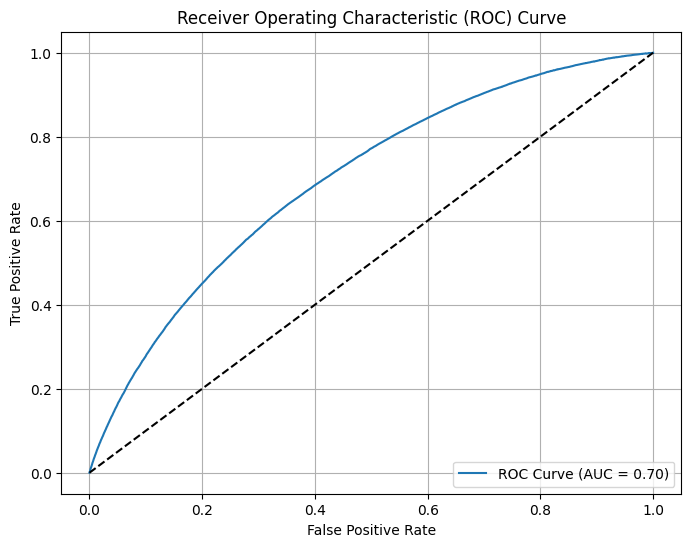

In [12]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predict probabilities
y_proba = model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

Feature Importance with XGBoost

/Users/cathaml/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:43:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


<Figure size 1000x600 with 0 Axes>

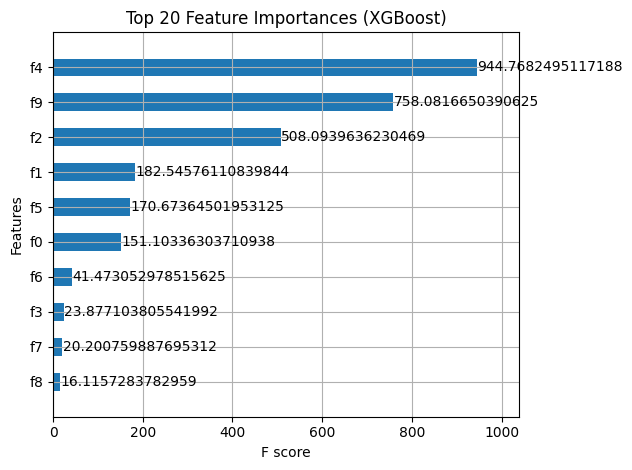

In [14]:
from xgboost import XGBClassifier, plot_importance
import matplotlib.pyplot as plt

# Train an XGBoost model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train_resampled, y_train_resampled)

# Plot feature importances (built-in method)
plt.figure(figsize=(10, 6))
plot_importance(xgb, max_num_features=20, importance_type='gain', height=0.5)
plt.title('Top 20 Feature Importances (XGBoost)')
plt.tight_layout()
plt.show()